<a href="https://colab.research.google.com/github/vladargunov/msai_devops_hw/blob/master/Devops_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
!pip install bs4 -qqq
import requests
import bs4
import pandas as pd
from IPython.display import Image, display
from tqdm import tqdm

  Preparing metadata (setup.py) ... done


# Construct CountryScraper

Country Scraper is intended to collect data from Wikiperdia website about the country's name, capital, area, and population.

Each method of such class is self explanatory and is later used to construct final datatable. See example after the instantiation of the class.

In [371]:
class CountryScraper:
    def __init__(self):
        # Get list of all countries
        self.all_countries_list = self.get_all_available_countries()

    def get_all_available_countries(self):
        all_countries_link = (
            "https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area"
        )
        html_page = bs4.BeautifulSoup(
            requests.get(all_countries_link).content, "html.parser"
        )
        all_links = list(html_page.find_all("a"))

        all_countries_list = []
        # Introduce two flags about Russia and Vatican, as first and last countries
        russia_appeared = False
        vatican_appeared = False
        for link in all_links:
            try:
                if "/wiki/" in link.get("href"):
                    # Append only between Russia and Vatican
                    country_name = link.get("title")
                    if country_name == "Russia":
                        russia_appeared = True
                    elif country_name == "Vatican City":
                        vatican_appeared = True
                    # Add country to the list
                    if russia_appeared:
                        all_countries_list.append(country_name)
                    if vatican_appeared:
                        break

            except TypeError:
                print(f"Error occured here: {link}")

        return all_countries_list

    def get_flag_link_of_country(self, country: str):
        base_link = "https://upload.wikimedia.org/wikipedia/"
        search_link = f"https://en.wikipedia.org/wiki/Flag_of_{country}#/media/File:Flag_of_{country}.svg"

        response = bs4.BeautifulSoup(requests.get(search_link).content, "html.parser")
        list_response = str(response.contents).split("\n")

        for row in list_response:
            if base_link in row:
                # Find indices of start and end links in row
                start_id = row.find(base_link)
                end_id = row.find(f".svg.png")

                img_link = row[start_id : (end_id + len(".svg.png"))]

                return img_link

        raise FileNotFoundError(f"Image of country {country} was not found!")

    def display_flag_clountry(self, country):
        flag_link = self.get_flag_link_of_country(country)
        display(Image(flag_link))

    def get_capital_country(self, country):
        country_url = f"https://en.wikipedia.org/wiki/{country}"

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response = str(response.contents).split("\n")

        for row in response:
            if "Capital" in row:
                capital_string = row[row.find("Capital") :]
                capital_string = capital_string[
                    (capital_string.find("title") + len("title") + 2) :
                ]
                capital_string = capital_string[: capital_string.find(">") - 1]
                return capital_string

        raise FileNotFoundError(f"Capital of country {country} was not found!")

    def get_population_country(self, country: str):
        country_url = f"https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population"

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response_text = response.text.split("\n")

        # Get population value
        for row_id, row in enumerate(response_text):
            if country in row:
                population = response_text[row_id + 2]
                break

        population = population.strip().replace(",", "")

        population_return = ""
        # Try each subsequent value for case of integer
        for num in population:
            try:
                population_int = int(num)
                population_return += num
            except ValueError:
                break
        return population_return

    def get_area_country(self, country: str):
        country_url = (
            f"https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_area"
        )

        response = bs4.BeautifulSoup(requests.get(country_url).content, "html.parser")

        response_text = response.text.split("\n")

        # Get population value
        for row_id, row in enumerate(response_text):
            if country in row:
                area = response_text[row_id + 1]
                break

        area = area.strip().replace(",", "")

        area_return = ""
        # Try each subsequent value for case of integer
        for num in area:
            try:
                area_int = int(num)
                area_return += num
            except ValueError:
                break
        return area_return

    def get_info_about_country(self, country):
        flag_url = self.get_flag_link_of_country(country)
        capital = self.get_capital_country(country)
        area = self.get_area_country(country)
        population = self.get_population_country(country)

        return {
            "Country": country,
            "Flag Image URL": flag_url,
            "Capital": capital,
            "Area (km^2)": area,
            "Population": population,
        }

    def construct_table(self, selected_countries=None):
        data_rows = []
        iterator_countries = (
            self.all_countries_list
            if selected_countries is None
            else selected_countries
        )
        for country in tqdm(iterator_countries):
            try:
                data_row = self.get_info_about_country(country)
                data_rows.append(data_row)
            except Exception as e:
                print(f"Error in retrieving data from country {country}")

        return pd.DataFrame(data_rows)


## Example

Here I construct a simple table of data from all the countries liste in wikipedia. Note, however, that some of the countries were not able to be parsed since they do not contain part of the required data. However, 280 countries were successfully parsed.

In [372]:
cs = CountryScraper()

In [373]:
data = cs.construct_table()

  1%|          | 2/318 [00:03<07:07,  1.35s/it]

Error in retrieving data from country Antarctica


  4%|▍         | 12/318 [00:32<13:17,  2.61s/it]

Error in retrieving data from country Democratic Republic of the Congo


  4%|▍         | 13/318 [00:32<09:47,  1.93s/it]

Error in retrieving data from country no


  4%|▍         | 14/318 [00:33<07:30,  1.48s/it]

Error in retrieving data from country Danish Realm


  5%|▌         | 16/318 [00:35<06:24,  1.27s/it]

Error in retrieving data from country Danish Realm


 22%|██▏       | 70/318 [02:57<10:33,  2.56s/it]

Error in retrieving data from country Republic of the Congo


 26%|██▋       | 84/318 [03:37<08:57,  2.30s/it]

Error in retrieving data from country Western Sahara


 30%|██▉       | 95/318 [04:02<06:24,  1.73s/it]

Error in retrieving data from country Syria


 40%|███▉      | 127/318 [05:25<08:27,  2.66s/it]

Error in retrieving data from country Republic of Ireland


 40%|████      | 128/318 [05:27<08:14,  2.60s/it]

Error in retrieving data from country Georgia (country)


 42%|████▏     | 132/318 [05:37<07:02,  2.27s/it]

Error in retrieving data from country Svalbard


 53%|█████▎    | 169/318 [07:13<06:05,  2.46s/it]

Error in retrieving data from country The Bahamas


 55%|█████▌    | 175/318 [07:28<05:49,  2.45s/it]

Error in retrieving data from country The Gambia


 57%|█████▋    | 182/318 [07:46<04:42,  2.08s/it]

Error in retrieving data from country Abkhazia


 58%|█████▊    | 185/318 [07:53<04:35,  2.07s/it]

Error in retrieving data from country State of Palestine


 60%|█████▉    | 190/318 [08:04<04:08,  1.94s/it]

Error in retrieving data from country Transnistria


 62%|██████▏   | 196/318 [08:18<03:57,  1.95s/it]

Error in retrieving data from country Republic of Artsakh


 63%|██████▎   | 201/318 [08:29<03:50,  1.97s/it]

Error in retrieving data from country Bir Tawil


 64%|██████▎   | 202/318 [08:30<02:58,  1.54s/it]

Error in retrieving data from country Terra nullius


 65%|██████▌   | 208/318 [08:42<02:58,  1.62s/it]

Error in retrieving data from country Danish Realm


 68%|██████▊   | 217/318 [09:04<04:00,  2.38s/it]

Error in retrieving data from country Federated States of Micronesia


 73%|███████▎  | 232/318 [09:39<02:25,  1.69s/it]

Error in retrieving data from country Heard Island and McDonald Islands


 74%|███████▍  | 235/318 [09:46<02:29,  1.80s/it]

Error in retrieving data from country Jan Mayen


 75%|███████▍  | 237/318 [09:50<02:36,  1.94s/it]

Error in retrieving data from country United States Virgin Islands


 82%|████████▏ | 260/318 [10:49<02:07,  2.19s/it]

Error in retrieving data from country Easter Island


 86%|████████▋ | 275/318 [11:26<01:26,  2.02s/it]

Error in retrieving data from country Bailiwick of Guernsey


 88%|████████▊ | 280/318 [11:38<01:21,  2.15s/it]

Error in retrieving data from country Collectivity of Saint Martin


 89%|████████▉ | 284/318 [11:48<01:17,  2.29s/it]

Error in retrieving data from country Bouvet Island


 94%|█████████▍| 300/318 [12:28<00:34,  1.94s/it]

Error in retrieving data from country United States Minor Outlying Islands


 95%|█████████▌| 303/318 [12:34<00:28,  1.93s/it]

Error in retrieving data from country Saba (island)


 96%|█████████▌| 306/318 [12:40<00:20,  1.71s/it]

Error in retrieving data from country Realm of New Zealand


 97%|█████████▋| 309/318 [12:45<00:14,  1.66s/it]

Error in retrieving data from country Clipperton Island


 98%|█████████▊| 311/318 [12:50<00:12,  1.85s/it]

Error in retrieving data from country Ashmore and Cartier Islands


 98%|█████████▊| 313/318 [12:53<00:07,  1.57s/it]

Error in retrieving data from country Spratly Islands


 99%|█████████▊| 314/318 [12:53<00:05,  1.25s/it]

Error in retrieving data from country Spratly Islands dispute


 99%|█████████▉| 315/318 [12:54<00:03,  1.03s/it]

Error in retrieving data from country Coral Sea Islands


100%|██████████| 318/318 [13:02<00:00,  2.46s/it]


In [380]:
# Patch of data to remove last two countries since they gave strange results
data = data.iloc[:-2]

The same dataframe is represented in Github repo as a csv file

In [385]:
data.head()

,Country,Flag Image URL,Capital,Area (km^2),Population
0,Russia,https://upload.wikimedia.org/wikipedia/en/thum...,Moscow,17098246,146424729
1,Canada,https://upload.wikimedia.org/wikipedia/commons...,Ottawa,9984670,40130200
2,China,https://upload.wikimedia.org/wikipedia/commons...,Beijing,9596961,1411750000
3,United States,https://upload.wikimedia.org/wikipedia/en/thum...,"Washington, D.C.",9833517,335038000
4,Brazil,https://upload.wikimedia.org/wikipedia/en/thum...,Brasília,8515767,203062512


You can also display an image of any requested flag of the country.

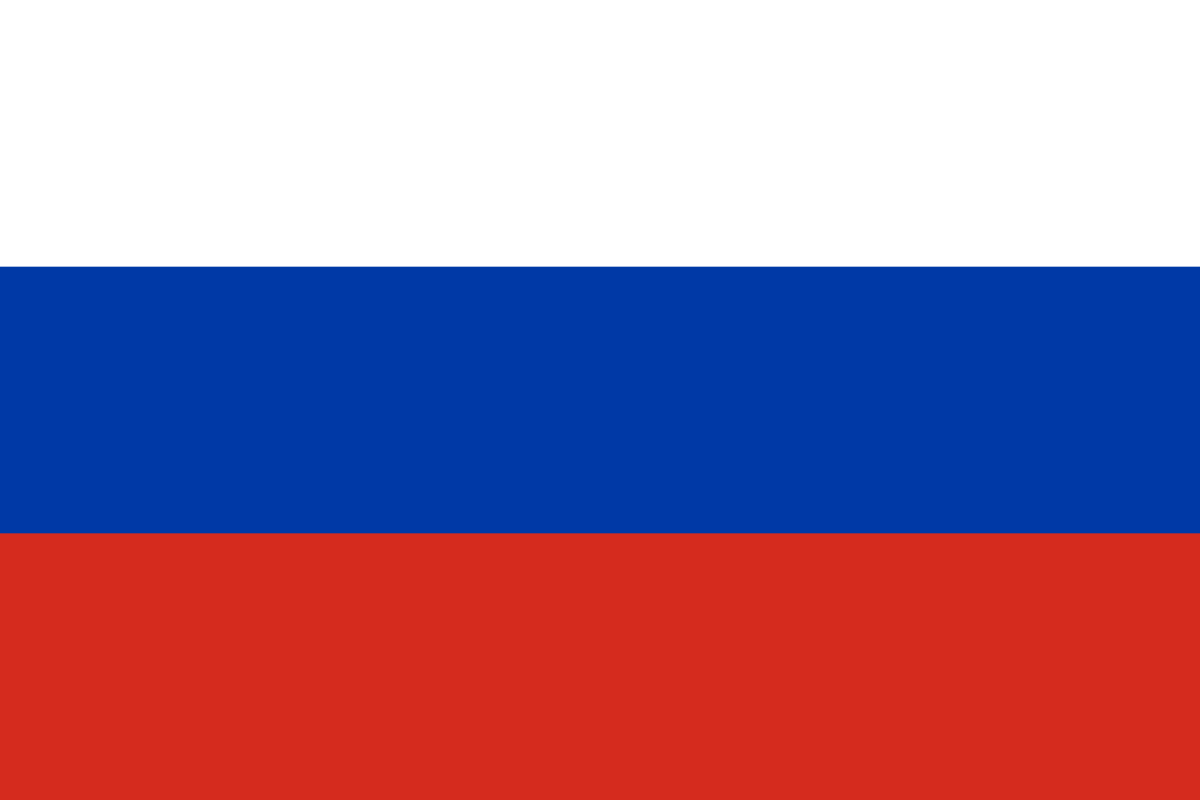

In [389]:
cs.display_flag_clountry('Russia')